## ATAC + MULTIOME SUPPORTING CELLS (april 2021)

### Label transfer with Seurat 

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.figdir = '/home/jovyan/MULTIOME_april2021/figures_supporting/'

/opt/conda/envs/atac_env/lib/python3.8/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

In [3]:
import rpy2.rinterface_lib.callbacks
import logging

In [4]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [5]:
import anndata2ri
anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R
## Install dependencies
#devtools::install_github("aertslab/RcisTarget")
#devtools::install_github("aertslab/AUCell")
        
#devtools::install_github("aertslab/cisTopic")
library(cisTopic)
library(Matrix)
library(Seurat)
library(dplyr)
library(data.table)
library(GenomicRanges)
library(EnsDb.Hsapiens.v86)
#library(cicero)
library(Signac)
#library(clustree)
library(Matrix)
library(reticulate)
#if (!requireNamespace("remotes", quietly = TRUE)) {
#  install.packages("remotes")
#}
#remotes::install_github("mojaveazure/seurat-disk")

library(SeuratDisk)

**Load data**

In [8]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/supporting_apr2021/"
experiment_prefix = 'supporting_'

Try to use the gene accessibility scores computed with Emma's method and integrate with matched scRNAseq samples annotated by Luz 

In [9]:
%%R -i outdir -i experiment_prefix -o ATAC_geneScores
Convert(paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5ad"),  
        dest = paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5seurat"), overwrite = TRUE)
ATAC_geneScores <- LoadH5Seurat(paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5seurat"))
ATAC_geneScores
print(table(ATAC_geneScores@meta.data$individual))


  F81  Hrv3 Hrv10 Hrv11 Hrv12 Hrv13 Hrv15 Hrv17 Hrv18 Hrv21 Hrv39 Hrv40 Hrv49 
 6618   364   726   219  1033  2406  1939  1828  1357  1745  3140  2448  3533 
Hrv50 Hrv58 Hrv59 
 5188   449  1022 


In [119]:
%%R -i outdir -i experiment_prefix -o RNAseq
Convert(paste0(outdir, experiment_prefix, "_RNAseq.h5ad"),  
        dest = paste0(outdir, experiment_prefix, "_RNAseq.h5seurat"), overwrite = TRUE)
RNAseq <- LoadH5Seurat(paste0(outdir, experiment_prefix, "_RNAseq.h5seurat"))
RNAseq
print(table(RNAseq@meta.data$individual))


  F81  Hrv3 Hrv10 Hrv11 Hrv12 Hrv13 Hrv15 Hrv17 Hrv18 Hrv21 Hrv39 Hrv40 Hrv49 
 5413   595  1711   306   403   851    72   845   681  1184   706  1394  2746 
Hrv58 Hrv59 
  863   224 


In [120]:
%%R -i RNAseq

print(table(RNAseq@meta.data$annotated_clusters)) 


FetalLeydig-like          Sertoli    Sertoli_WFDC2          coelEpi 
             231             4383              672              813 
     ovarianSurf         preGC_II        preGC_III  preGC_III_Notch 
            1209             1527             1033              583 
preGC_II_hypoxia     preGC_I_OSR1           sKITLG            sLGR5 
            1837             3880              356              783 
          sPAX8b           sPAX8m 
             427              260 


**Try label transfer with major cluster annotations**

In [121]:
%%R -i RNAseq -i ATAC_geneScores -o RNA2ATAC

# Normalize both RNA and ATAC data
RNAseq <- NormalizeData(object = RNAseq, verbose = TRUE)
ATAC_geneScores <- NormalizeData(object = ATAC_geneScores, verbose = TRUE)

# Find HVGs in both RNA and ATAC data
RNAseq  <- FindVariableFeatures(object = RNAseq, selection.method = "vst", nfeatures = 3000, verbose = TRUE)
ATAC_geneScores <- FindVariableFeatures(object = ATAC_geneScores, selection.method = "vst", nfeatures = 3000, verbose = TRUE)

# Find anchors to do integration using RNA as reference and ATAC as query 
transfer_anchors <- FindTransferAnchors(reference = RNAseq, query = ATAC_geneScores, 
    dims = 1:20, reduction = "cca")

# Transfer labels from RNA to ATAC
RNA2ATAC <- TransferData(anchorset = transfer_anchors, refdata = RNAseq@meta.data$annotated_clusters, dims = 1:20, weight.reduction = "cca",
                        prediction.assay = TRUE)

# Add metadata to ATAC
#ATAC_geneScores_labels <- AddMetaData(object = ATAC_geneScores, metadata = RNA2ATAC)

In [122]:
%%R -i RNA2ATAC -o predicted_probabilities -i ATAC_geneScores

ATAC_geneScores[['scores']] <- RNA2ATAC
ATAC_geneScores
DefaultAssay(ATAC_geneScores) <- "scores" # Change default assay 
predicted_probabilities <- as.data.frame(t(x = as.matrix(x = GetAssayData(object = ATAC_geneScores))))

In [123]:
predicted_probabilities

preGC-II  preGC-II-hypoxia     sLGR5  ovarianSurf  \
01-AAACGAAAGGCTCCTG-1  0.000000          0.000000  0.043931     0.000000   
01-AAACGAAAGTCCAGAG-1  0.000000          0.000000  0.933791     0.000000   
01-AAACGAACACCCATCT-1  0.001034          0.000000  0.000000     0.969513   
01-AAACGAACAGGTCTGC-1  0.000000          0.000000  0.032268     0.000000   
01-AAACGAAGTAGGGTCA-1  0.000000          0.000000  0.111867     0.000000   
...                         ...               ...       ...          ...   
10-TTTGAGGCATCATAGC-1  0.033126          0.061845  0.000000     0.461318   
10-TTTGCGCTCAAGTTGC-1  0.000000          0.000000  0.000000     0.000000   
10-TTTGGTTAGTTGCTTG-1  0.000000          0.267716  0.000000     0.693794   
10-TTTGTGTGTGCTGAAG-1  0.021461          0.009073  0.000000     0.018751   
10-TTTGTGTGTTAACCGT-1  0.000000          0.000000  0.000000     0.000000   

                       preGC-I-OSR1    sPAX8b  preGC-III  sKITLG   coelEpi  \
01-AAACGAAAGGCTCCTG-1      0.943185  0.012884   0.000000     0.0  0.000000   
01-AAACGAAAGTCCAGAG-1      0.066209  0.000000   0.000000     0.0  0.000000   
01-AAACGAACACCCATCT-1      0.000000  0.000000   0.000000     0.0  0.029453   
01-AAACGAACAGGTCTGC-1      0.939322  0.028410   0.000000     0.0  0.000000   
01-AAACGAAGTAGGGTCA-1      0.880139  0.001628   0.000000     0.0  0.000000   
...                             ...       ...        ...     ...       ...   
10-TTTGAGGCATCATAGC-1      0.000000  0.000000   0.172731     0.0  0.000000   
10-TTTGCGCTCAAGTTGC-1      0.000000  0.000000   0.018373     0.0  0.000000   
10-TTTGGTTAGTTGCTTG-1      0.000000  0.000000   0.022837     0.0  0.000000   
10-TTTGTGTGTGCTGAAG-1      0.000000  0.000000   0.403183     0.0  0.000000   
10-TTTGTGTGTTAACCGT-1      0.000000  0.000000   0.303943     0.0  0.000000   

                       sPAX8m  FetalLeydig-like  Sertoli  Sertoli-WFDC2  \
01-AAACGAAAGGCTCCTG-1     0.0               0.0      0.0            0.0   
01-AAACGAAAGTCCAGAG-1     0.0               0.0      0.0            0.0   
01-AAACGAACACCCATCT-1     0.0               0.0      0.0            0.0   
01-AAACGAACAGGTCTGC-1     0.0               0.0      0.0            0.0   
01-AAACGAAGTAGGGTCA-1     0.0               0.0      0.0            0.0   
...                       ...               ...      ...            ...   
10-TTTGAGGCATCATAGC-1     0.0               0.0      0.0            0.0   
10-TTTGCGCTCAAGTTGC-1     0.0               0.0      0.0            0.0   
10-TTTGGTTAGTTGCTTG-1     0.0               0.0      0.0            0.0   
10-TTTGTGTGTGCTGAAG-1     0.0               0.0      0.0            0.0   
10-TTTGTGTGTTAACCGT-1     0.0               0.0      0.0            0.0   

                       preGC-III-Notch       max  
01-AAACGAAAGGCTCCTG-1         0.000000  0.943185  
01-AAACGAAAGTCCAGAG-1         0.000000  0.933791  
01-AAACGAACACCCATCT-1         0.000000  0.969513  
01-AAACGAACAGGTCTGC-1         0.000000  0.939322  
01-AAACGAAGTAGGGTCA-1         0.006365  0.880139  
...                                ...       ...  
10-TTTGAGGCATCATAGC-1         0.270980  0.461318  
10-TTTGCGCTCAAGTTGC-1         0.981627  0.981627  
10-TTTGGTTAGTTGCTTG-1         0.015653  0.693794  
10-TTTGTGTGTGCTGAAG-1         0.547532  0.547532  
10-TTTGTGTGTTAACCGT-1         0.696057  0.696057  

[34015 rows x 15 columns]

In [124]:
predicted_probabilities.columns

Index(['preGC-II', 'preGC-II-hypoxia', 'sLGR5', 'ovarianSurf', 'preGC-I-OSR1',
       'sPAX8b', 'preGC-III', 'sKITLG', 'coelEpi', 'sPAX8m',
       'FetalLeydig-like', 'Sertoli', 'Sertoli-WFDC2', 'preGC-III-Notch',
       'max'],
      dtype='object')

In [125]:
predicted_probabilities.columns = ['preGC_II', 'preGC_II_hypoxia', 'sLGR5', 'ovarianSurf', 'preGC_I_OSR1', 
       'sPAX8b', 'preGC_III', 'sKITLG', 'coelEpi', 'sPAX8m',
       'FetalLeydig-like', 'Sertoli', 'Sertoli_WFDC2', 'preGC_III_Notch',
       'max']

**Save the predicted annotations to the gene activity anndata object for ATAC**

In [126]:
gene_data = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

In [127]:
gene_data

AnnData object with n_obs × n_vars = 34015 × 17356
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual', 'preGC_II', 'sLGR5', 'ovarianSurf', 'preGC_III', 'preGC_II_hypoxia', 'preGC_I_OSR1', 'sPAX8', 'preGC_III_Notch', 'sKITLG', 'coelEpi', 'Sertoli', 'Sertoli_WFDC2', 'FetalLeydig-like', 'max', 'mean_gene_activity', 'sPAX8b', 'sPAX8m'
    var: 'gene_id'
    uns: 'individual_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopic_30', 'X_umap'
    obsp: 'connectivities', 'distances'

In [128]:
for pred in predicted_probabilities.columns: 
    print(pred)
    gene_data.obs[pred] = predicted_probabilities[pred]

preGC_II
preGC_II_hypoxia
sLGR5
ovarianSurf
preGC_I_OSR1
sPAX8b
preGC_III
sKITLG
coelEpi
sPAX8m
FetalLeydig-like
Sertoli
Sertoli_WFDC2
preGC_III_Notch
max


In [10]:
gonads_colors = ['#c466b0',  '#60bddb', '#e64e74','#edb7b7', '#779eed', '#7b9e99',  '#ebd3c3' , '#d96884','#70ccbe', 
               '#7b9e99', '#edb7b7', '#91bd80', '#d9a5c3','#cc8fdb', '#71a2c7','#bdb380',  '#d4db81', '#ebd3c3',  '#dba781',  '#60bddb', 
               '#e08b8b', '#d9abb7','#aad3f2', '#e64e74',  ]

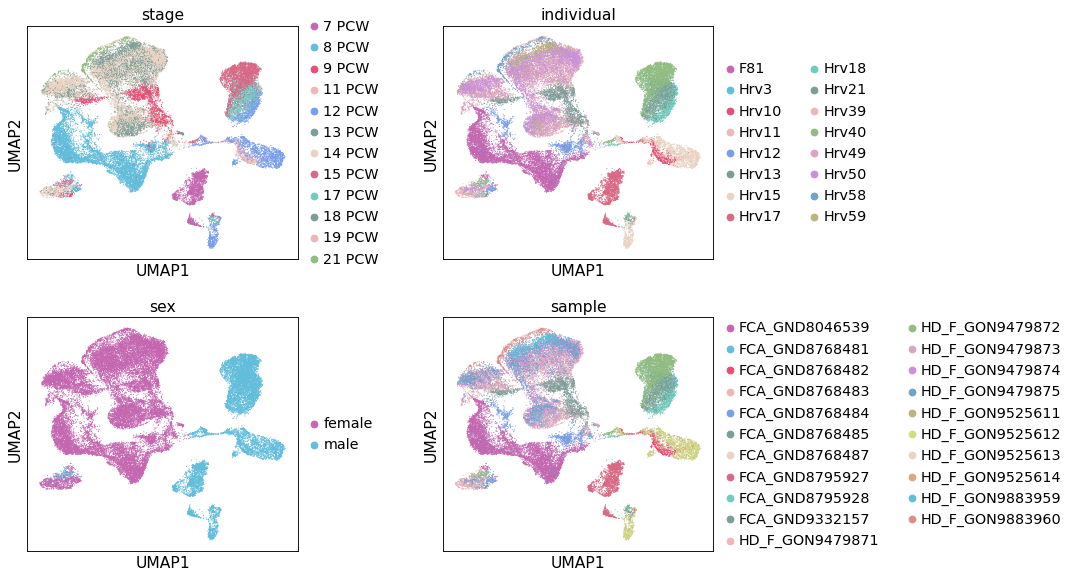

In [130]:
sc.pl.umap(gene_data, color = ['stage', 'individual', 'sex', 'sample'], ncols = 2, wspace = 0.4, 
           palette = gonads_colors, save = "_noharmony.pdf")

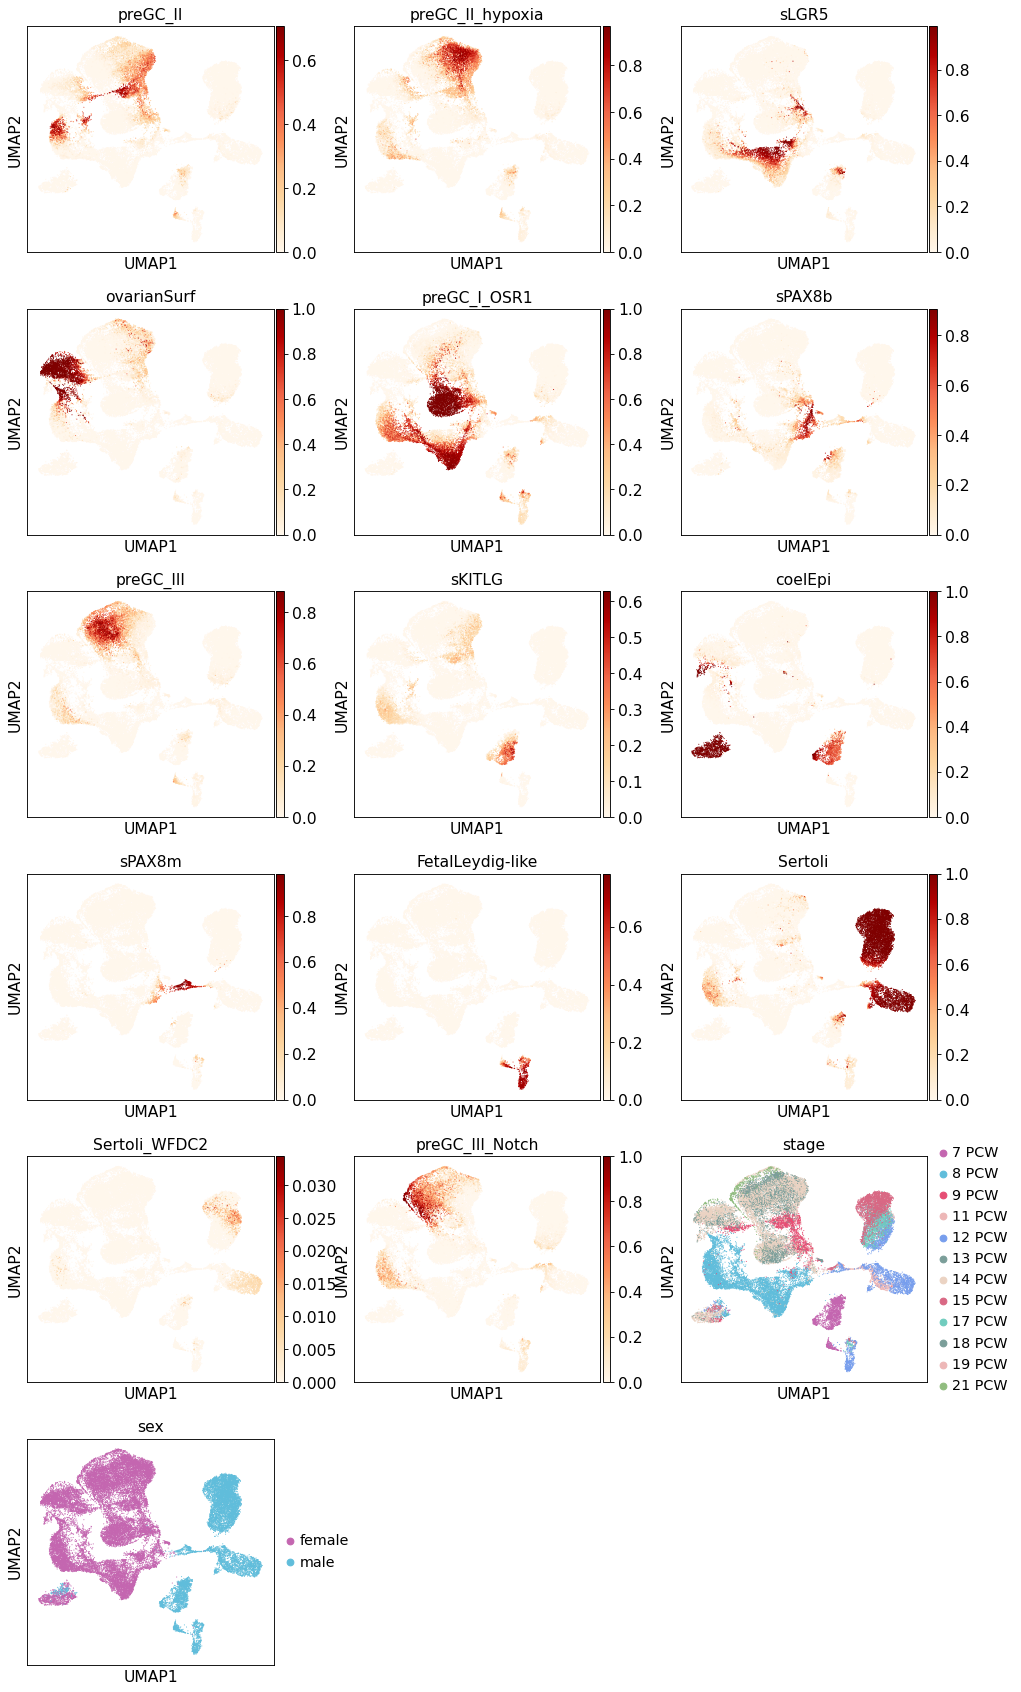

In [131]:
sc.pl.umap(gene_data, color = ['preGC_II', 'preGC_II_hypoxia', 'sLGR5', 'ovarianSurf', 'preGC_I_OSR1',
       'sPAX8b', 'preGC_III', 'sKITLG', 'coelEpi', 'sPAX8m',
       'FetalLeydig-like', 'Sertoli', 'Sertoli_WFDC2', 'preGC_III_Notch',
       'stage', 'sex'], ncols = 3, color_map = 'OrRd', save = "_supporting_probs_noharmony.pdf")

#### Look at average gene activity scores to identify cycling population

This was suggested by Luz 

In [69]:
gene_data.X

array([[33., 29., 29., ...,  4.,  8.,  6.],
       [32., 29., 29., ..., 12., 22., 16.],
       [42., 36., 36., ...,  5.,  6.,  4.],
       ...,
       [56., 43., 43., ...,  3.,  4.,  3.],
       [42., 34., 34., ...,  5.,  9.,  6.],
       [40., 31., 31., ...,  5.,  9.,  6.]], dtype=float32)

In [70]:
mean_by_cell = gene_data.X.mean(axis=1)
mean_by_cell

array([55.805775, 55.05393 , 54.80341 , ..., 56.18668 , 55.098812,
       54.565224], dtype=float32)

In [71]:
means = pd.DataFrame(mean_by_cell, columns=['mean_gene_activity'], index=gene_data.obs_names)
means.head()

mean_gene_activity
01-AAACGAAAGGCTCCTG-1           55.805775
01-AAACGAAAGTCCAGAG-1           55.053928
01-AAACGAACACCCATCT-1           54.803410
01-AAACGAACAGGTCTGC-1           56.315453
01-AAACGAAGTAGGGTCA-1           54.643810

In [72]:
gene_data.obs['mean_gene_activity'] = means

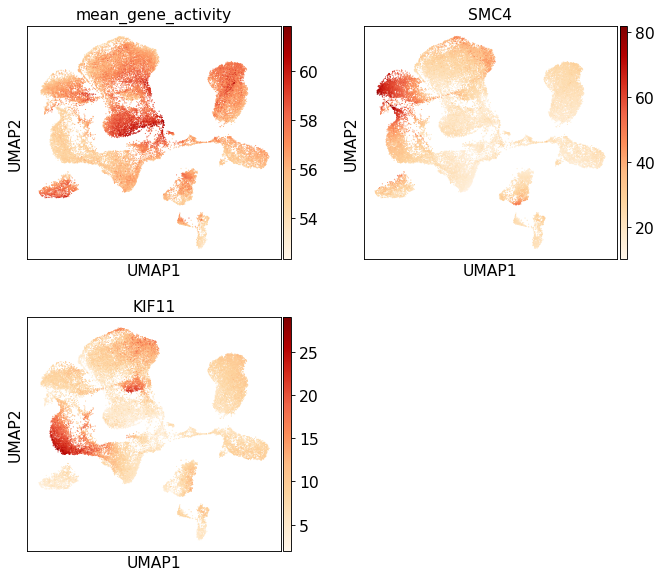

In [73]:
sc.pl.umap(gene_data, color = ['mean_gene_activity',  'SMC4', 'KIF11'], ncols = 2, color_map = "OrRd")

In [74]:
cell_cycle_genes = [x.strip() for x in open(file='/nfs/users/nfs_v/vl6/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in gene_data.var_names]
print(s_genes)
g2m_genes = [x for x in g2m_genes if x in gene_data.var_names]
print(g2m_genes)

['MCM5', 'FEN1', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'DTL', 'UHRF1', 'HELLS', 'NASP', 'WDR76', 'CCNE2', 'POLD3', 'MSH2', 'ATAD2', 'RRM2', 'CDC45', 'CDC6', 'TIPIN', 'BLM', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8']
['TPX2', 'TOP2A', 'NUF2', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'RANGAP1', 'CDCA2', 'CDCA8', 'KIF23', 'AURKA', 'PSRC1', 'ANLN', 'CKAP5', 'CTCF', 'NEK2', 'CBX5', 'CENPA']


In [75]:
#sc.pl.umap(gene_data, color = s_genes, color_map = "OrRd")

In [76]:
#sc.pl.umap(gene_data, color = g2m_genes, color_map = "OrRd")

In [77]:
gene_data.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

**Save the predicted annotations to the peaks anndata object for ATAC**

In [132]:
adata = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")
adata

AnnData object with n_obs × n_vars = 33909 × 170503
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0_75', 'preGC_II', 'sLGR5', 'ovarianSurf', 'preGC_III', 'preGC_II_hypoxia', 'preGC_I_OSR1', 'sPAX8', 'preGC_III_Notch', 'sKITLG', 'coelEpi', 'Sertoli', 'Sertoli_WFDC2', 'FetalLeydig-like', 'max', 'sPAX8b', 'sPAX8m'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopic_30', 'X_umap'
    varm:

In [133]:
for pred in predicted_probabilities.columns: 
    print(pred)
    adata.obs[pred] = predicted_probabilities[pred]

preGC_II
preGC_II_hypoxia
sLGR5
ovarianSurf
preGC_I_OSR1
sPAX8b
preGC_III
sKITLG
coelEpi
sPAX8m
FetalLeydig-like
Sertoli
Sertoli_WFDC2
preGC_III_Notch
max


In [134]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

### Harmony integration

In [135]:
adata

AnnData object with n_obs × n_vars = 33909 × 170503
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0_75', 'preGC_II', 'sLGR5', 'ovarianSurf', 'preGC_III', 'preGC_II_hypoxia', 'preGC_I_OSR1', 'sPAX8', 'preGC_III_Notch', 'sKITLG', 'coelEpi', 'Sertoli', 'Sertoli_WFDC2', 'FetalLeydig-like', 'max', 'sPAX8b', 'sPAX8m'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopic_30', 'X_umap'
    varm:

In [136]:
# Extract PCA matrix and batch array
n_pcs = 30
pca = adata.obsm['X_cistopic_30'][:, 0:(n_pcs)]
batch = adata.obs['individual']

In [137]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)
set.seed(1000)
hem <- HarmonyMatrix(pca, batch, theta=0, lambda = 1, do_pca=FALSE, verbose = FALSE)
hem = data.frame(hem)

In [138]:
# Add harmony values to the anndata object
adata.obsm['X_harmony'] = hem.values

In [139]:
sc.pp.neighbors(adata, use_rep= 'X_harmony', random_state=1234)
sc.tl.umap(adata)

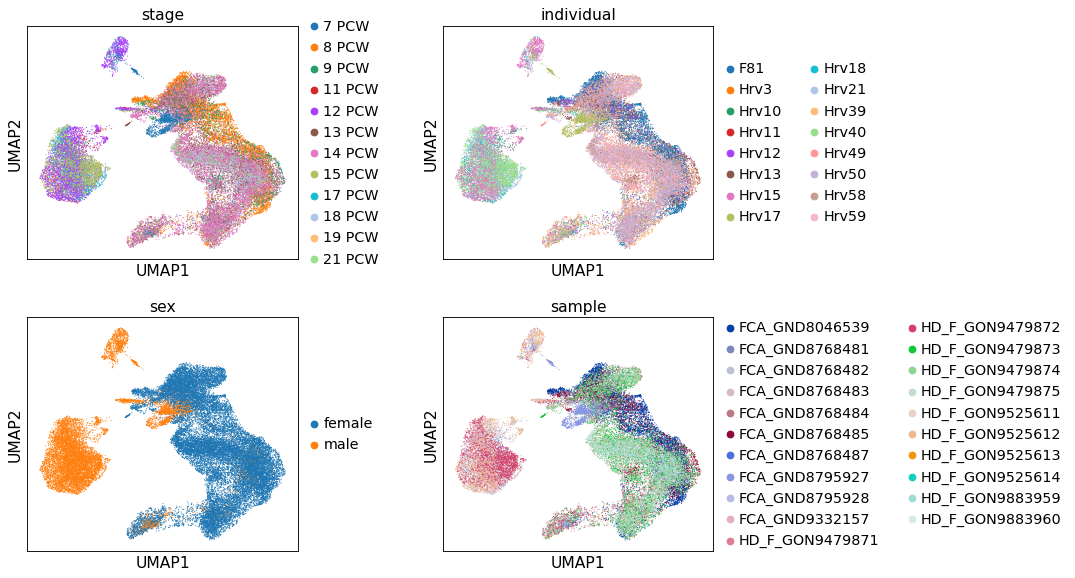

In [140]:
sc.pl.umap(adata, color = ['stage', 'individual', 'sex', 'sample'], ncols = 2, wspace = 0.4, 
            save = "_after_harmony.pdf")

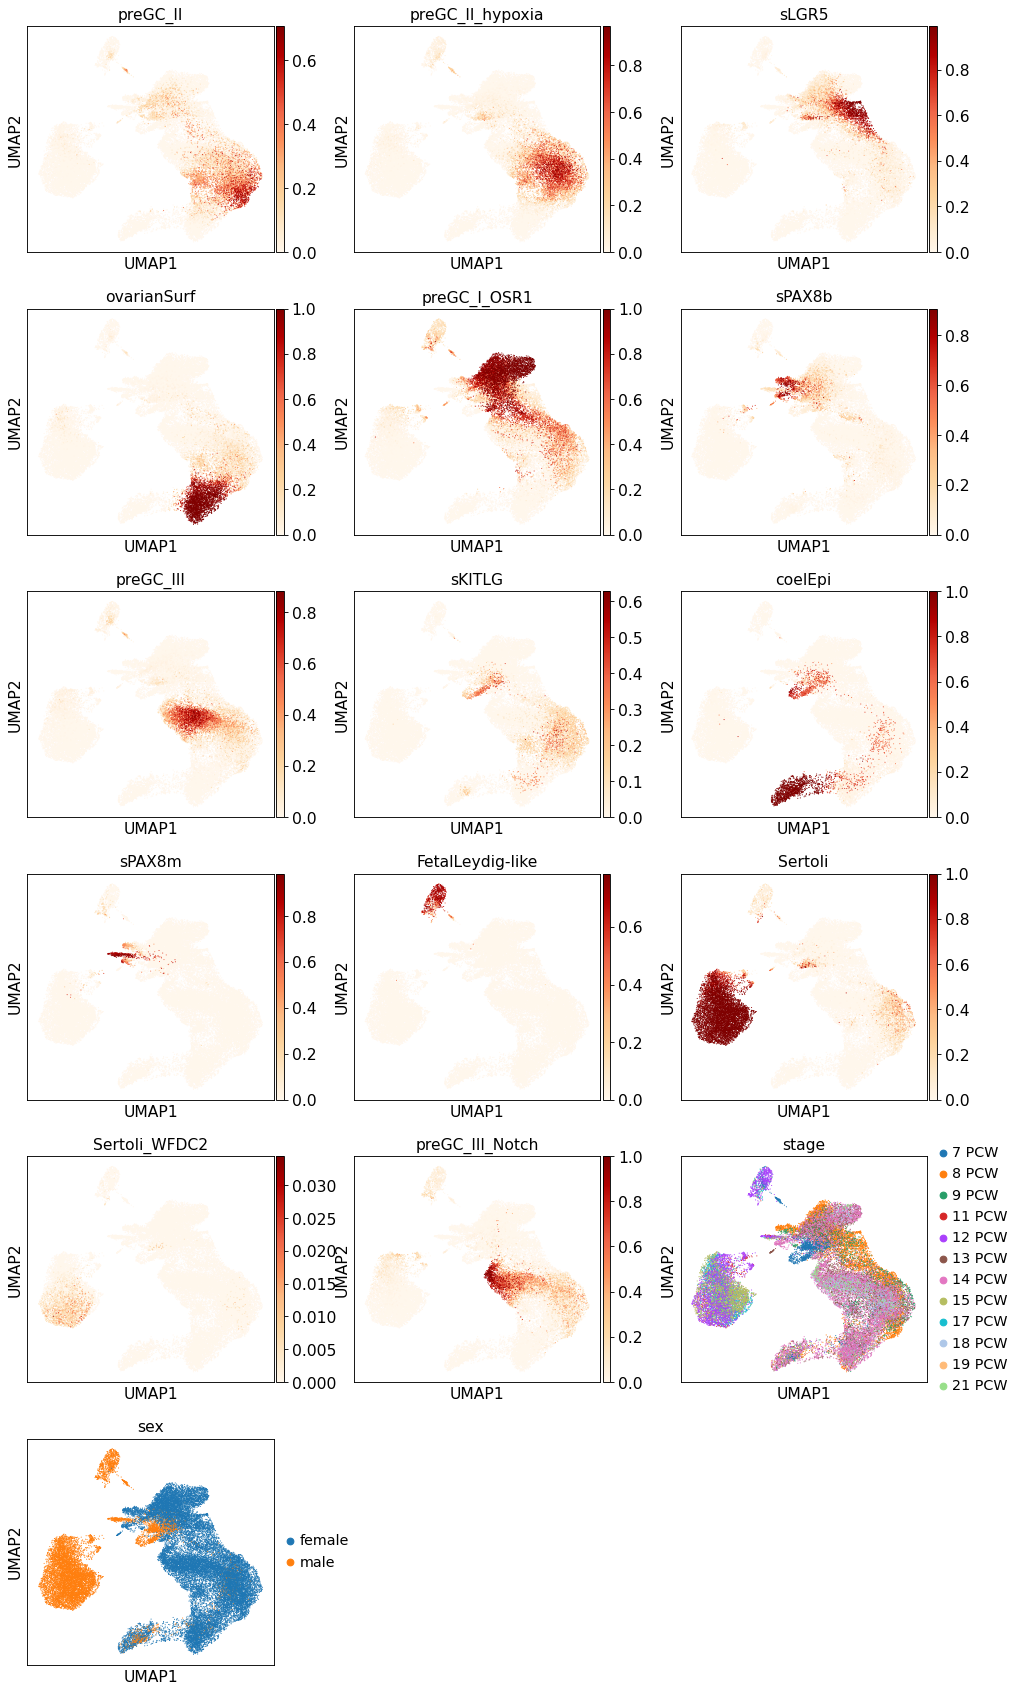

In [141]:
sc.pl.umap(adata, color = ['preGC_II', 'preGC_II_hypoxia', 'sLGR5', 'ovarianSurf', 'preGC_I_OSR1',
       'sPAX8b', 'preGC_III', 'sKITLG', 'coelEpi', 'sPAX8m',
       'FetalLeydig-like', 'Sertoli', 'Sertoli_WFDC2', 'preGC_III_Notch',
       'stage', 'sex'], ncols = 3, color_map = 'OrRd', save = "_supporting_probs_after_harmony.pdf")

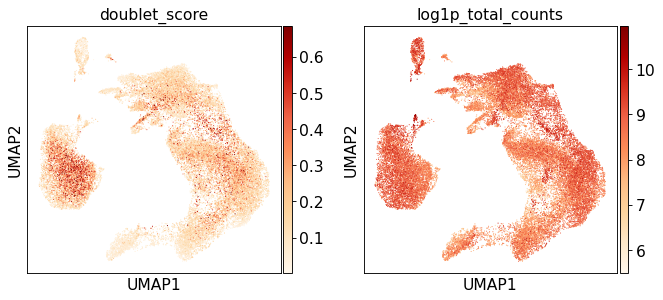

In [103]:
sc.pl.umap(adata, color = ['doublet_score', 'log1p_total_counts'], color_map = 'OrRd')

In [104]:
adata.write(outdir + experiment_prefix + "_harmony_ATAC.wCisTopic.h5ad")

#### Visualize position in the manifold of dual ATAC samples

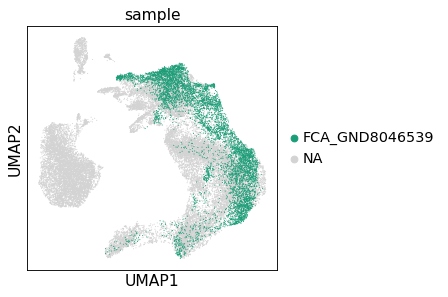

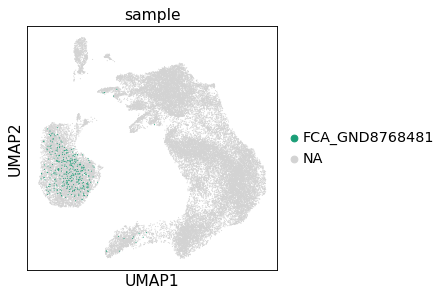

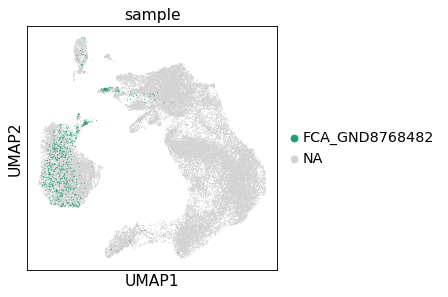

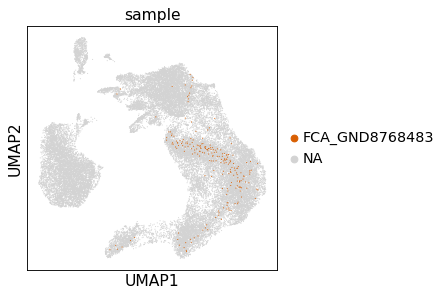

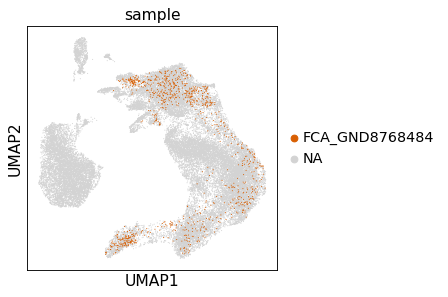

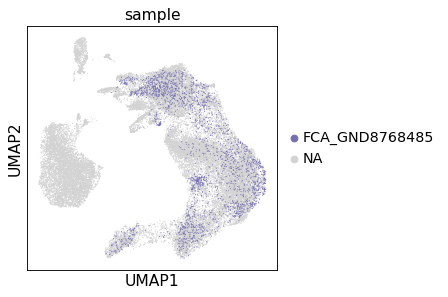

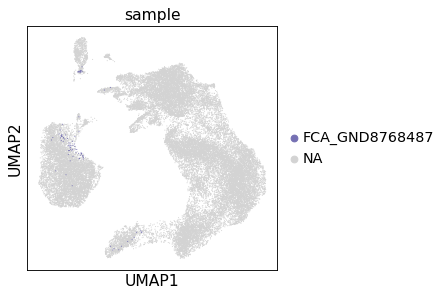

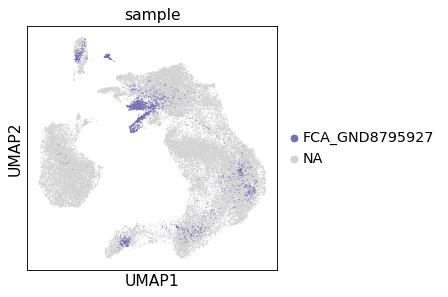

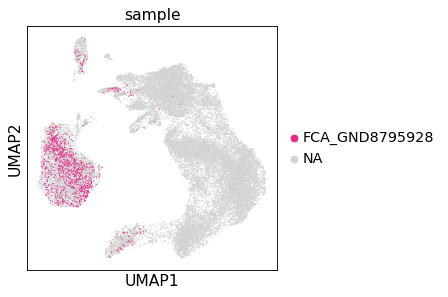

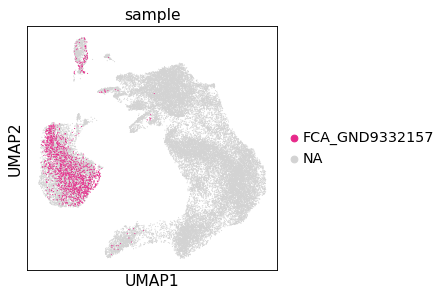

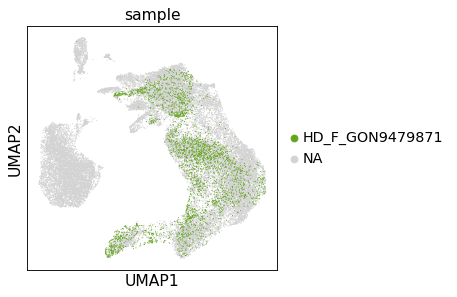

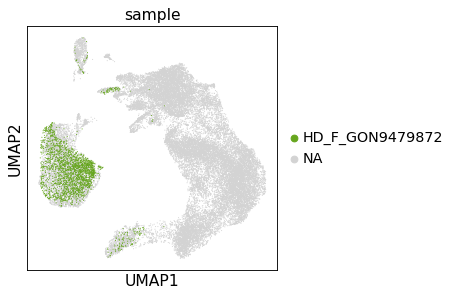

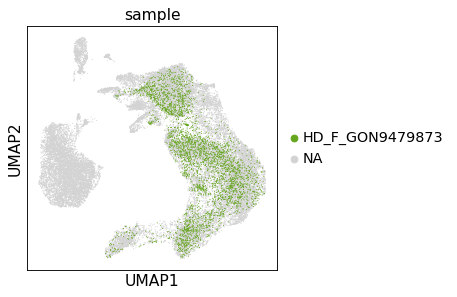

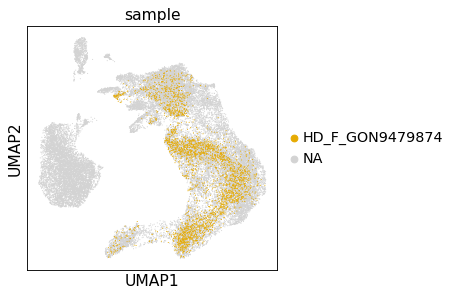

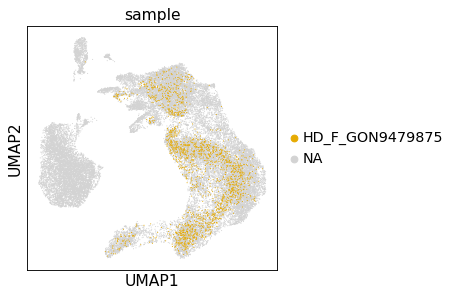

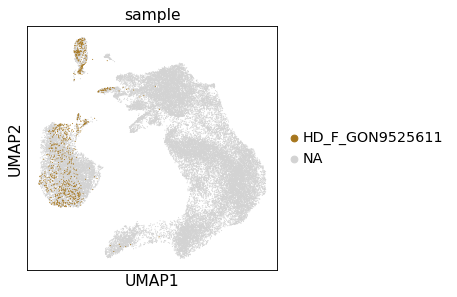

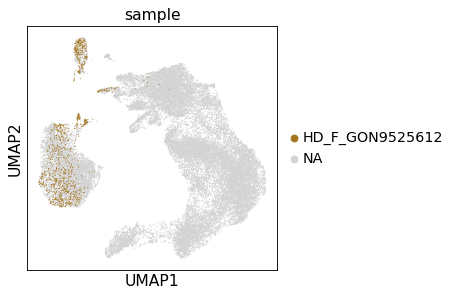

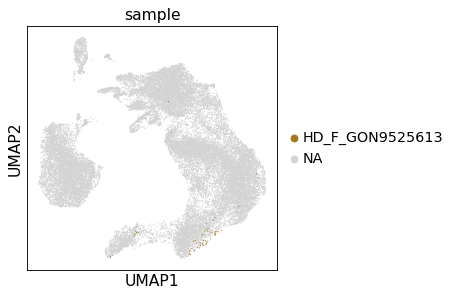

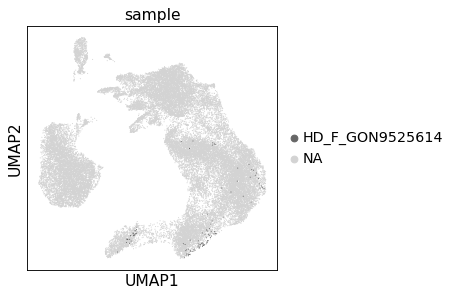

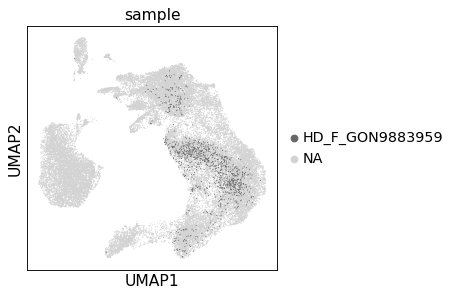

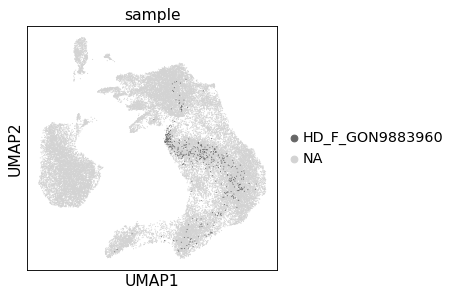

In [105]:
for sample in np.unique(adata.obs['sample']):
    sc.pl.umap(adata, color = 'sample', groups = sample, palette = 'Dark2', save = sample + ".pdf")

#### Clustering

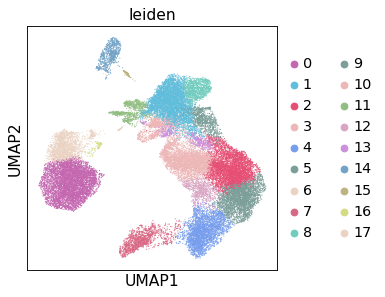

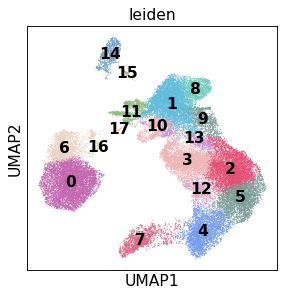

In [146]:
sc.tl.leiden(adata, resolution= 0.8, random_state = 1234)
sc.pl.umap(adata, color='leiden',save='_supporting_clustering.pdf')
sc.pl.umap(adata, color='leiden',legend_loc='on data',save='_supporting_clustering_clusnumbers.pdf', palette = gonads_colors)

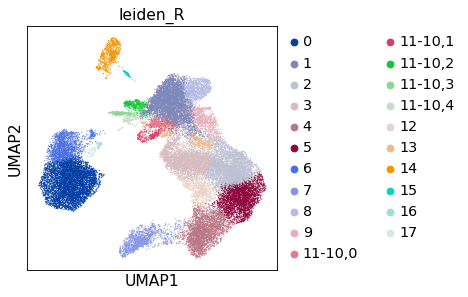

In [147]:
# Subcluster 11 to separate the 2 sPAX8 populations
sc.tl.leiden(adata, resolution=0.2, restrict_to = ('leiden', ['11', '10']), random_state = 1234)
sc.pl.umap(adata, color='leiden_R')

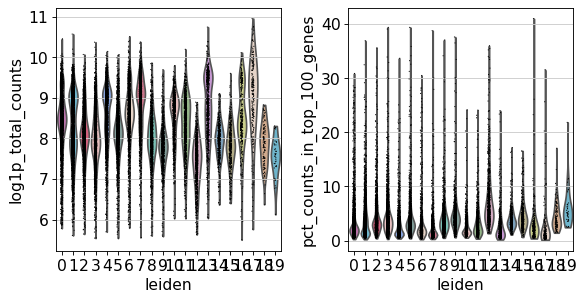

In [116]:
sc.pl.violin(adata, keys = ['log1p_total_counts', 'pct_counts_in_top_100_genes'], groupby = 'leiden')

In [168]:
clusters = {'0' : 'Sertoli', '6' : 'Sertoli', '16' : 'Sertoli', '14' : 'FetalLeydig-like', '15' : 'FetalLeydig-like',
            '1' : 'preGC_I_OSR1', '8' : 'preGC_I_OSR1', '13' : 'preGC_I_OSR1', '7' : 'coelEpi', '4' : 'ovarianSurf', '5' : 'preGC_II', '12' : 'preGC_II',
           '2' : 'preGC_II_hypoxia', '3' : 'preGC_III_Notch', '9' : 'sLGR5', '11-10,0' : 'sLGR5', '11-10,1' : 'sKITLG',
           '11-10,2' : 'sPAX8b', '11-10,4' : 'sPAX8b', '11-10,3' : 'sPAX8m', '17' : 'sPAX8b'}
adata.obs['cell_type'] = adata.obs['leiden_R'].map(clusters)
adata.obs['cell_type'].value_counts(dropna = False)

Sertoli             7417
preGC_I_OSR1        6625
preGC_II_hypoxia    4227
preGC_II            3880
preGC_III_Notch     3620
ovarianSurf         3161
sLGR5               1453
coelEpi             1331
FetalLeydig-like     864
sPAX8b               627
sKITLG               436
sPAX8m               268
Name: cell_type, dtype: int64

... storing 'cell_type' as categorical
... storing 'sex_clusters' as categorical
... storing 'new_clusters' as categorical


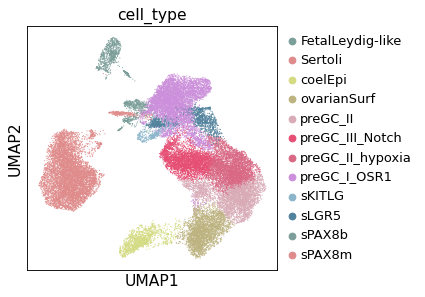

In [169]:
sc.pl.umap(adata, color = 'cell_type',
           legend_fontsize = "small", legend_fontweight = "normal", save = "_clusters_supporting.pdf")

In [15]:
gonads_colors = ['#7b9e99','#91bd80','#bdb380','#d4db81','#70ccbe','#cc8fdb','#edb7b7','#d9abb7','#e08b8b', 
                '#e64e74', '#aad3f2', '#60bddb']

In [171]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype("category")
adata.obs['cell_type'] = adata.obs['cell_type'].cat.reorder_categories([
   'coelEpi', 'sKITLG', 'sLGR5', 'sPAX8b', 'sPAX8m', 'preGC_I_OSR1',
    'ovarianSurf', 'preGC_II', 'preGC_II_hypoxia', 'preGC_III_Notch',
    'Sertoli','FetalLeydig-like'
])

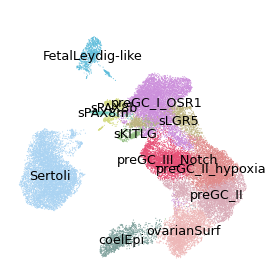

In [174]:
sc.pl.umap(adata, color = 'cell_type', palette = gonads_colors,
           legend_fontsize = 11.5, legend_fontweight = "normal", legend_loc = 'on data',
           frameon = False, title = " ",
           save = "_clusters_supporting_2.pdf")

In [ ]:
sc.pl.umap(adata, color = 'cell_type', palette = gonads_colors,
           legend_fontsize = "medium", legend_fontweight = "medium",
            title = " ", frameon = True,
           save = "_clusters_supporting_3.pdf")

In [176]:
#### Split PAX8 and CoelomicEpithelium in males and females 

adata.obs['sex_clusters'] = adata.obs['cell_type'].astype(str) + "_" + adata.obs['sex'].astype(str)
adata.obs['sex_clusters'].value_counts()

Sertoli_male               7416
preGC_I_OSR1_female        6435
preGC_II_hypoxia_female    4099
preGC_II_female            3769
preGC_III_Notch_female     3620
ovarianSurf_female         3031
coelEpi_female             1002
sLGR5_female                979
FetalLeydig-like_male       861
sPAX8b_female               604
sLGR5_male                  474
sKITLG_male                 430
coelEpi_male                329
sPAX8m_male                 264
preGC_I_OSR1_male           190
ovarianSurf_male            130
preGC_II_hypoxia_male       128
preGC_II_male               111
sPAX8b_male                  23
sKITLG_female                 6
sPAX8m_female                 4
FetalLeydig-like_female       3
Sertoli_female                1
Name: sex_clusters, dtype: int64

In [10]:
adata.obs['new_clusters'] = np.where(adata.obs['cell_type'].isin(['sLGR5']), 
                                     adata.obs['sex_clusters'], adata.obs['cell_type'])

In [11]:
adata.obs['new_clusters'].value_counts()

Sertoli             7417
preGC_I_OSR1        6625
preGC_II_hypoxia    4227
preGC_II            3880
preGC_III_Notch     3620
ovarianSurf         3161
coelEpi             1331
sLGR5_female         979
FetalLeydig-like     864
sPAX8b               627
sLGR5_male           474
sKITLG               436
sPAX8m               268
Name: new_clusters, dtype: int64

In [13]:
adata.obs['new_clusters'].to_csv(outdir + experiment_prefix + "new_clusters.csv")

In [12]:
adata.write(outdir + experiment_prefix + "_harmony_ATAC.wCisTopic.h5ad")

... storing 'new_clusters' as categorical


In [9]:
adata = sc.read(outdir + experiment_prefix + "_harmony_ATAC.wCisTopic.h5ad")
adata

AnnData object with n_obs × n_vars = 33909 × 170503
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0_75', 'preGC_II', 'sLGR5', 'ovarianSurf', 'preGC_III', 'preGC_II_hypoxia', 'preGC_I_OSR1', 'sPAX8', 'preGC_III_Notch', 'sKITLG', 'coelEpi', 'Sertoli', 'Sertoli_WFDC2', 'FetalLeydig-like', 'max', 'sPAX8b', 'sPAX8m', 'leiden', 'leiden_R', 'cell_type', 'sex_clusters', 'new_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'cellatac_clusters_colors', 'individual_colors', 'leiden', 'leiden_R_color

In [94]:
outdir

'/nfs/team292/vl6/my_MULTIOME_dir/supporting_feb2021/'

#### Matrixplot of label transfer predictions vs leiden clusters

In [18]:
adata.obs.columns

Index(['cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage',
       'individual', 'doublet_score', 'doublet_score_0_75', 'preGC_II',
       'sLGR5', 'ovarianSurf', 'preGC_III', 'preGC_II_hypoxia', 'preGC_I_OSR1',
       'sPAX8', 'preGC_III_Notch', 'sKITLG', 'coelEpi', 'Sertoli',
       'Sertoli_WFDC2', 'FetalLeydig-like', 'max', 'sPAX8b', 'sPAX8m',
       'leiden', 'leiden_R', 'cell_type', 'sex_clusters', 'new_clusters'],
      dtype='object')

In [19]:
obs = adata.obs[[ 'sLGR5', 'ovarianSurf', 'preGC_II', 'preGC_III', 'preGC_II_hypoxia', 'preGC_I_OSR1',
      'preGC_III_Notch', 'sKITLG', 'coelEpi', 'Sertoli',
       'Sertoli_WFDC2', 'FetalLeydig-like',  'sPAX8b', 'sPAX8m',]]

In [20]:
matrix = obs[[ 'sLGR5', 'ovarianSurf', 'preGC_II', 'preGC_III', 'preGC_II_hypoxia', 'preGC_I_OSR1',
      'preGC_III_Notch', 'sKITLG', 'coelEpi', 'Sertoli',
       'Sertoli_WFDC2', 'FetalLeydig-like',  'sPAX8b', 'sPAX8m']].values
matrix.shape

(33909, 14)

In [23]:
plotting_obs = adata.obs[['leiden', 'cell_type']]
plotting_obs.shape

(33909, 2)

In [24]:
plotting_probs = [ 'sLGR5', 'ovarianSurf', 'preGC_II', 'preGC_III', 'preGC_II_hypoxia', 'preGC_I_OSR1',
      'preGC_III_Notch', 'sKITLG', 'coelEpi', 'Sertoli',
       'Sertoli_WFDC2', 'FetalLeydig-like',  'sPAX8b', 'sPAX8m']
plotting_var_dict = {'probs' : plotting_probs, 'random_string' : [str(i) for i in range(14)]}
plotting_var = pd.DataFrame(plotting_var_dict)
plotting_var = plotting_var.set_index('probs')
plotting_var.head()
plotting_var.shape

(14, 1)

In [25]:
plotting_adata = anndata.AnnData(X = matrix, obs = plotting_obs, var = plotting_var)
plotting_adata

AnnData object with n_obs × n_vars = 33909 × 14
    obs: 'leiden', 'cell_type'
    var: 'random_string'

In [26]:
ordered_probs = [  'coelEpi', 'sKITLG', 'sLGR5', 'sPAX8b', 'sPAX8m', 'preGC_I_OSR1',
    'ovarianSurf', 'preGC_II', 'preGC_II_hypoxia','preGC_III', 'preGC_III_Notch',
    'Sertoli','FetalLeydig-like'
        ]

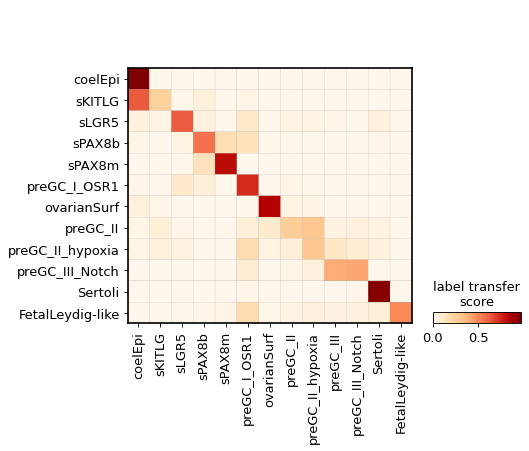

In [27]:
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs, groupby = 'cell_type', cmap = 'OrRd',
                  save = '_supporting_matrixplot.pdf', colorbar_title = 'label transfer\nscore')

In [191]:
adata.var['peaks_formatted'] = [i.replace(":", "-") for i in adata.var_names]
adata.var = adata.var.set_index('peaks_formatted')
adata.var.to_csv(outdir + experiment_prefix + "adata_var_for_cicero.csv")

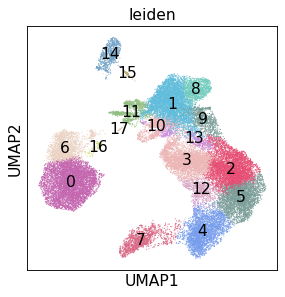

In [11]:
sc.pl.umap(adata, color='leiden',legend_loc='on data', legend_fontsize = 'medium', legend_fontweight = 'medium',
           save='_supporting_clustering_clusnumbers.pdf', palette = gonads_colors)

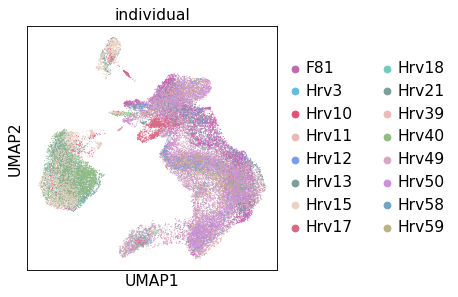

In [12]:
sc.pl.umap(adata, color='individual',legend_fontsize = 'medium', legend_fontweight = 'medium',
           save='_supporting_individual.pdf', palette = gonads_colors)

In [15]:
np.unique(adata.obs.stage)

array(['11 PCW', '12 PCW', '13 PCW', '14 PCW', '15 PCW', '17 PCW',
       '18 PCW', '19 PCW', '21 PCW', '7 PCW', '8 PCW', '9 PCW'],
      dtype=object)

In [16]:
# Transform the stage variable in numeric to plot the PCW as a gradient
pcws_dict = {'11 PCW' : 11, '12 PCW' : 12, '13 PCW' : 13, '14 PCW' : 14, '15 PCW' : 15, '17 PCW' : 17,
       '18 PCW' : 18, '19 PCW' : 19, '21 PCW' : 21, '7 PCW' : 7, '8 PCW' : 8, '9 PCW' : 9}
adata.obs['stage_numeric'] = adata.obs['stage'].map(pcws_dict)
adata.obs['stage_numeric'].value_counts(dropna = False)

14    8525
8     7632
13    3526
12    3296
15    2413
9     2399
7     1821
17    1736
18    1022
11     726
21     449
19     364
Name: stage_numeric, dtype: int64

In [21]:
adata.obs['stage_numeric'] = adata.obs['stage_numeric'].astype(float)

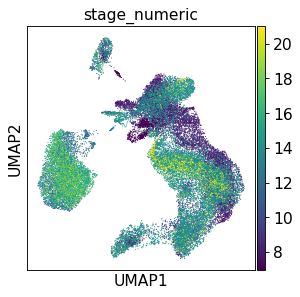

In [23]:
sc.pl.umap(adata, color='stage_numeric',legend_fontsize = 'medium', 
           legend_fontweight = 'medium', color_map = 'viridis',
           save='_supporting_stage.pdf')

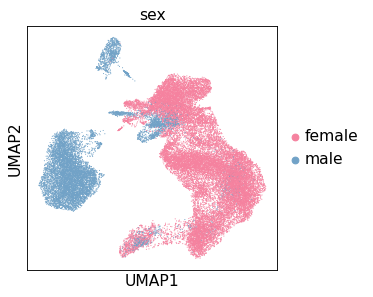

In [24]:
sex_colors = ['#f5829f', '#71a2c7']
sc.pl.umap(adata, color='sex',legend_fontsize = 'medium', legend_fontweight = 'medium',
           save='_supporting_sex.pdf', palette = sex_colors)

### Import annotations from dualRNA Luz 

In [91]:
annotations_dualRNA_female = pd.read_csv("/nfs/team292/lg18/with_valentina/gonadsV1_freezed/dual_snRNAsnATAC_female_Hrv39_supporting.csv", index_col = 0)
annotations_dualRNA_male = pd.read_csv("/nfs/team292/lg18/with_valentina/gonadsV1_freezed/dual_snRNAsnATAC_male_Hrv15_supporting.csv", index_col = 0)
annotations_dualRNA = annotations_dualRNA_female.append(annotations_dualRNA_male)
annotations_dualRNA.head()

n_genes           sample  donor  \
HD_F_GON9525421_AAAGGACGTCATTGTC    10526  HD_F_GON9525421  Hrv39   
HD_F_GON9525421_AACAGATAGGACCAGG     2578  HD_F_GON9525421  Hrv39   
HD_F_GON9525421_AACGGTAAGTTTGGTA     3434  HD_F_GON9525421  Hrv39   
HD_F_GON9525421_AAGCATGAGTCGCTAG     2690  HD_F_GON9525421  Hrv39   
HD_F_GON9525421_AAGCCTCCAGCCTAAC     5265  HD_F_GON9525421  Hrv39   

                                          Library_ATAC  Library_RNA      iRods_path  \
HD_F_GON9525421_AAAGGACGTCATTGTC  HD_F_GON9525613        HD_F_GON9525421        ...   
HD_F_GON9525421_AACAGATAGGACCAGG  HD_F_GON9525613        HD_F_GON9525421        ...   
HD_F_GON9525421_AACGGTAAGTTTGGTA  HD_F_GON9525613        HD_F_GON9525421        ...   
HD_F_GON9525421_AAGCATGAGTCGCTAG  HD_F_GON9525613        HD_F_GON9525421        ...   
HD_F_GON9525421_AAGCCTCCAGCCTAAC  HD_F_GON9525613        HD_F_GON9525421        ...   

                                  percent_mito  n_counts  batch  \
HD_F_GON9525421_AAAGGACGTCATTGTC      0.002590   24332.0      2   
HD_F_GON9525421_AACAGATAGGACCAGG      0.000633    2185.0      2   
HD_F_GON9525421_AACGGTAAGTTTGGTA      0.000416    6796.0      2   
HD_F_GON9525421_AAGCATGAGTCGCTAG      0.010041    5450.0      2   
HD_F_GON9525421_AAGCCTCCAGCCTAAC      0.001442    8707.0      2   

                                  scrublet_score  scrublet_cluster_score  \
HD_F_GON9525421_AAAGGACGTCATTGTC        0.152941                0.164087   
HD_F_GON9525421_AACAGATAGGACCAGG        0.223529                0.266968   
HD_F_GON9525421_AACGGTAAGTTTGGTA        0.092437                0.101056   
HD_F_GON9525421_AAGCATGAGTCGCTAG        0.110588                0.104072   
HD_F_GON9525421_AAGCCTCCAGCCTAAC        0.205882                0.266968   

                                    zscore   bh_pval  bonf_pval  is_doublet  \
HD_F_GON9525421_AAAGGACGTCATTGTC  0.425994  0.933846        1.0       False   
HD_F_GON9525421_AACAGATAGGACCAGG  2.490427  0.384962        1.0       False   
HD_F_GON9525421_AACGGTAAGTTTGGTA -0.838790  0.933846        1.0       False   
HD_F_GON9525421_AAGCATGAGTCGCTAG -0.778259  0.933846        1.0       False   
HD_F_GON9525421_AAGCCTCCAGCCTAAC  2.490427  0.384962        1.0       False   

                                  leiden       clusters  leiden_R  
HD_F_GON9525421_AAAGGACGTCATTGTC       3    sLGR5-sPAX8       3.0  
HD_F_GON9525421_AACAGATAGGACCAGG       3    sLGR5-sPAX8       3.0  
HD_F_GON9525421_AACGGTAAGTTTGGTA       0  preGCc_CSRNP1       3.0  
HD_F_GON9525421_AAGCATGAGTCGCTAG       0  preGCc_CSRNP1       3.0  
HD_F_GON9525421_AAGCCTCCAGCCTAAC       3    sLGR5-sPAX8       3.0

In [92]:
annotations_dualRNA['clusters'].value_counts(dropna = False)

Sertoli                967
FetalLeydig            391
preGCc_CSRNP1          162
OvarianSurf            116
Sertoli_cycling        110
sLGR5_sPAX8            100
preGC_RDH10             86
sLGR5-sPAX8             55
OvarianSurf_cycling     39
Name: clusters, dtype: int64

In [93]:
adata.obs[['code', 'sample']].value_counts()

code  sample         
01    FCA_GND8046539     6600
06    HD_F_GON9479873    3526
07    HD_F_GON9479874    3135
05    HD_F_GON9479871    2955
17    HD_F_GON9479872    2413
13    FCA_GND8768485     2399
08    HD_F_GON9479875    2039
15    FCA_GND8795927     1821
18    FCA_GND9332157     1736
16    FCA_GND8795928     1357
03    FCA_GND8768484     1032
09    HD_F_GON9883959    1022
20    HD_F_GON9525612     946
19    HD_F_GON9525611     907
12    FCA_GND8768482      726
10    HD_F_GON9883960     449
11    FCA_GND8768481      364
02    FCA_GND8768483      219
22    HD_F_GON9525614     111
04    FCA_GND8768487       86
21    HD_F_GON9525613      66
dtype: int64

In [94]:
annotations_dualRNA.index = [i.replace("HD_F_GON9525421_", "21-") for i in annotations_dualRNA.index]
annotations_dualRNA.index = [i.replace("HD_F_GON9525422_", "22-") for i in annotations_dualRNA.index]
annotations_dualRNA.index = [i.replace("HD_F_GON9525419_", "19-") for i in annotations_dualRNA.index]
annotations_dualRNA.index = [i.replace("HD_F_GON9525420_", "20-") for i in annotations_dualRNA.index]

In [95]:
annotations_dualRNA.index = [i + "-1" for i in annotations_dualRNA.index]

In [96]:
dualRNA_mapping = annotations_dualRNA['clusters'].to_dict()

In [97]:
adata.obs['dualRNA_label'] = adata.obs_names.map(dualRNA_mapping)

In [98]:
adata.obs['dualRNA_label'].value_counts(dropna = False)

NaN                    32252
Sertoli                  952
FetalLeydig              383
Sertoli_cycling          110
sLGR5_sPAX8               99
OvarianSurf               73
OvarianSurf_cycling       24
preGCc_CSRNP1             12
preGC_RDH10                3
sLGR5-sPAX8                1
Name: dualRNA_label, dtype: int64

In [99]:
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].fillna('scATAC-seq only')

In [100]:
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].str.replace('sLGR5_sPAX8', 'Sertoli')
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].str.replace('sLGR5-sPAX8', 'Sertoli')
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].str.replace('OvarianSurf_cycling', 'ovarianSurf')
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].str.replace('OvarianSurf', 'ovarianSurf')
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].str.replace('Sertoli_cycling', 'Sertoli')
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].str.replace('preGC_RDH10', 'preGC_III_NOTCH')
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].str.replace('preGCc_CSRNP1', 'preGCc_II')



In [101]:
adata.obs['dualRNA_label'].value_counts(dropna = False)

scATAC-seq only    32252
Sertoli             1162
FetalLeydig          383
ovarianSurf           97
preGCc_II             12
preGC_III_NOTCH        3
Name: dualRNA_label, dtype: int64

In [102]:
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].astype(str)
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].astype("category")

adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].cat.reorder_categories([ 
                               'ovarianSurf', 'preGCc_II', 'preGC_III_NOTCH', 'Sertoli',
    'FetalLeydig', 'scATAC-seq only' ])

In [103]:
adata.obs['dualRNA_label'].value_counts()

scATAC-seq only    32252
Sertoli             1162
FetalLeydig          383
ovarianSurf           97
preGCc_II             12
preGC_III_NOTCH        3
Name: dualRNA_label, dtype: int64

In [104]:
gonads_colors = ['#edb7b7', '#d9abb7','#e64e74', '#aad3f2', '#60bddb' ,'aliceblue', ]

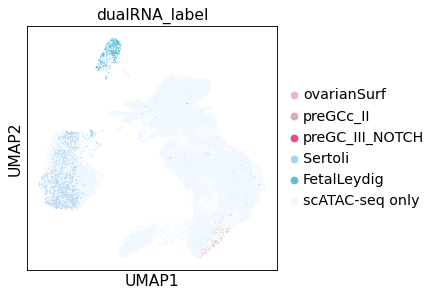

In [105]:
sc.pl.umap(adata, color = "dualRNA_label", save = "_supporting_dual.pdf", 
           palette = gonads_colors)

In [270]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
       plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
                       dpi=300, orientation='portrait', format= 'pdf', optimize=True)

In [271]:
adata.obs['leiden'] = adata.obs['leiden'].astype(str)

<ipython-input-270-2ff8f9db0dfc>:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error two minor releases later
  ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',


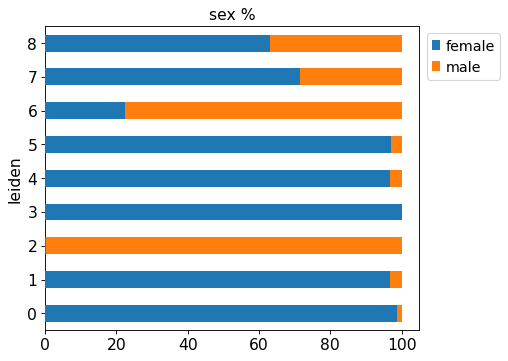

In [279]:
Barplot('sex', adata, var='leiden', height=5)

<ipython-input-95-2ff8f9db0dfc>:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error two minor releases later
  ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',


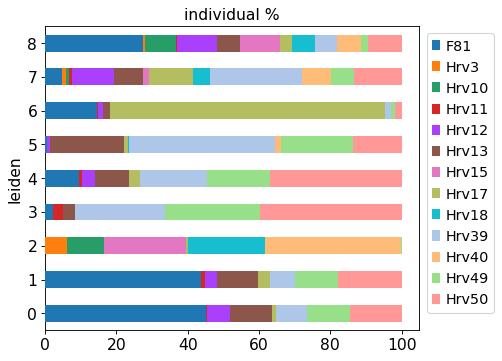

In [98]:
Barplot('individual', adata, var='leiden', height=5)

In [99]:
adata

AnnData object with n_obs × n_vars = 30075 × 171085
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'preGCc-CSRNP1', 'sLGR5', 'sKITLG', 'ovarianSurf', 'preGC-RDH10', 'preGCm-OSR1', 'sPAX8', 'coelEpi', 'Sertoli', 'Sertoli-NR4A1', 'Sertoli-WFDC2', 'max', 'leiden', 'dualRNA_label'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap', 'leiden', 'leiden_colors', 'dualRNA_label_colors'
    obsm: 'X_cistopic_3

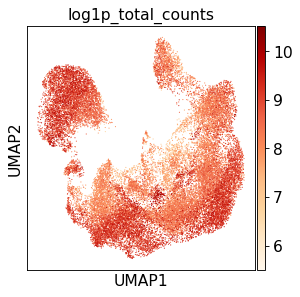

In [164]:
sc.pl.umap(adata, color = "log1p_total_counts", color_map = 'OrRd')

#### End of notebook

In [109]:
adata.obs[['sample', 'individual', 'stage', 'sex']].value_counts().to_csv('/home/jovyan/ATAC_metadata.csv', index=True, header=True)